# Summarize Growth and Nucleation Rates
There are continually new voids which grow large enough to appear and small enough to disappear from microscopy.
We assume these rates correspond to the nucleation and dissolution rates.

The goal of this notebook is to establish an estimate for these rates by fitting a model which explains the appearance and disapperance of voids.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from pathlib import Path
from scipy import stats
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
run_directory = '../data/8bitTIFF-video26-575C/'

Derived

In [3]:
run_directory = Path(run_directory)
run_name = run_directory.name
out_directory = Path('output') / run_name

## Load in Data
We need the tracked voids.

In [4]:
tracks = pd.read_json(out_directory / 'tracks.json', lines=True)
print(f'Loaded {len(tracks)} distinct tracks')

Loaded 1662 distinct tracks


In [5]:
long_tracks = tracks.query('total_frames > 10')
print(f'Found {len(long_tracks)} voids that appeared for more than a few frames')

Found 549 voids that appeared for more than a few frames


Narrow down to things that appear and disappear during the run

In [6]:
buffer = 10
last_frame = tracks['end_frame'].max()
long_tracks = long_tracks.query(f'start_frame > {buffer} and end_frame < {last_frame - buffer}')
print(f'Found {len(long_tracks)} voids that appear then disappear during the movie')

Found 513 voids that appear then disappear during the movie


Eliminate those which start and exit near the side

In [7]:
out_of_frame = long_tracks['touches_side'].apply(lambda x: any(x[-buffer:]) or any(x[:buffer]))
long_tracks = long_tracks[~ out_of_frame]
print(f'Found {len(long_tracks)} which do not move in or out of frame.')

Found 485 which do not move in or out of frame.


## Evaluating Qualitatively
Let's start by examining the data. How many new voids appear and disappear within a certain bin of times.

In [8]:
bins = np.linspace(long_tracks['start_frame'].min(), long_tracks['end_frame'].max(), 64, dtype=int)
width = bins[1] - bins[0]
print(f'Made {len(bins)} bins that are each {width} frames wide')

Made 64 bins that are each 13 frames wide


Make the counts

In [9]:
appear_counts, _ = np.histogram(long_tracks['start_frame'], bins=bins)
disappear_counts, _ = np.histogram(long_tracks['end_frame'], bins=bins)

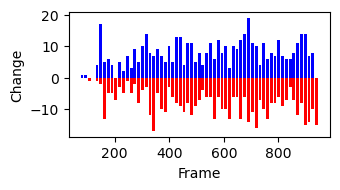

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.bar(bins[:-1], appear_counts, width=width * 0.8, color='blue')
ax.bar(bins[:-1], -disappear_counts, width=width*0.8, color='red')

ax.set_xlabel('Frame')
ax.set_ylabel('Change')
fig.tight_layout()
fig.savefig(out_directory / 'figures' / 'nucleation-and-dissolution-over-time.png', dpi=320)

To my eye, the rates seem to be gradually growing over time (for 575C)

## Setting up the Models
We have a few different options for explaining the nucleation of voids, all of which rely on assuming a "nuclation rate"
We do not directly measure the nucleation rate direction but only the number of voids which appear and disappear between frames.
The two are related, which lets us estimate a rate given the data.

For nucleation, we assume a certain rate unit area/volume which means we can describe the distribution of the number of nucleation events as a [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). 

For dissolution, we assume _each void_ has a certain probability of disappearing over time. The number of dissolution events is related to the number of voids, so we assume a [Binomial Distribution](https://en.wikipedia.org/wiki/Binomial_distribution) to explain the number of events per time.

We will fit both of these models under a few simplifying assumptions:
1. The rates of dissolution or do not change over time. This is a constraint we will relax later.
2. The rate of nucleation is unaffected by the number of voids present. This assumption may be problematic, as voids likely inhibit growth of new voids because they absorb vanacies before they could cluster to form new voids.
3. Dissolution rates are unaffected by size. Probably not true either, larger voids are less bound to disappear immediately
4. No voids appear then disappear between two frames. Our training set is composed of voids that are present for many frames so that we are focused on rates of "long-lived voids" appearing and dissolving.

Start by measuring the change at each frame

In [11]:
frames = np.arange(long_tracks['start_frame'].min(), long_tracks['end_frame'].max() + 1)
start_by_frame = long_tracks['start_frame'].value_counts().to_dict()
end_by_frame = long_tracks['end_frame'].value_counts().to_dict()
change_by_frame = pd.DataFrame({
    'frame': frames,
    'appeared': [start_by_frame.get(i, 0) for i in frames],  # Number appeared in this frame
    'disappeared': [end_by_frame.get(i, 0) for i in frames],  # Number that disappeared between this and next
})


Compute by how much the amount changes between each frame

In [12]:
change_by_frame['delta'] = change_by_frame['appeared']  # It increases by the number in appeared in this farmae
change_by_frame['delta'][1:] -= change_by_frame['disappeared'].values[:-1]  # Decreases by number that disappeared from last frame

In [13]:
change_by_frame['total'] = change_by_frame['delta'].cumsum()

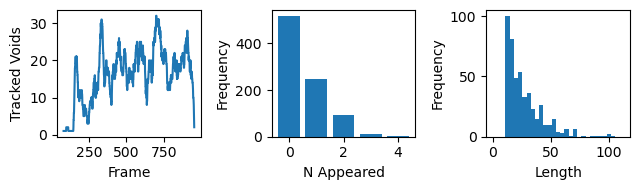

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.))

# Plot the total over time
ax = axs[0]
ax.plot(change_by_frame['frame'], change_by_frame['total'])
ax.set_xlabel('Frame')
ax.set_ylabel('Tracked Voids')

# Plot the distribution of number appeared
ax = axs[1]
counts = change_by_frame['appeared'].value_counts()
ax.bar(counts.index, counts)
ax.set_xlabel('N Appeared')
ax.set_ylabel('Frequency')

# Plot the distribution of number appeared
ax = axs[2]
bin_max = np.percentile(long_tracks['total_frames'], 99)
ax.hist(long_tracks['total_frames'], bins=np.linspace(0, bin_max, 32))
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')


fig.tight_layout()

*Note*: For at least 575C, the distributions seem to describe our data well. The number appearing in each frame follows a Poisson distribution with a small &lambda; and the path lengths follow a [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution). 

Estimate the parameters given coarse statistics

In [15]:
nuc_rate_start = change_by_frame['appeared'].mean()  # The mean of a Poisson dist is the lambda parameter

In [16]:
dis_prob_start = 1. / long_tracks['total_frames'].mean()  # Each individual is dissolves following the a Bernoulli process, so we can estimate the rate from the number of survivals

Use these as starting points to drive a larger optimization

In [17]:
def generate_distributions(start_count: int, nuc_rate: float, dissolve_prob: float) -> tuple[stats.rv_discrete, stats.rv_discrete]:
    """Generate the probability distributions for the number of voids nucleated and dissolved.
    
    Args:
        start_count: Number of voids in the current frame
        nuc_rate: Nucleation rate
        dissolve_prob: Probability that a void will dissolve
    Returns:
        - Distribution of expected number of dissolution events
        - Distribution of expected number of nucleation events
    """
    
    # The nucleation rate is unaffected by system state
    nuc_dist = stats.poisson(nuc_rate)
    
    # The dissolution rate depends on the number of active voids
    dis_dist = stats.binom(start_count, dissolve_prob)
    
    return nuc_dist, dis_dist

In [18]:
def log_loss(frame_stats: pd.DataFrame, nuc_rate: float, dist_prob: float) -> float:
    """Compute the log-likelihood of observing the per-frame changes
    
    Args:
        frame_stats: Holds the number of appearances, 
            total number of voids, and number of dissolutions per frame
        nuc_rate, dist_prob: See parameters for `generate_distributions`
    Returns:
        Log-likelihood of all data
    """
    
    # Start by making the distributions
    app_dist, dis_dist = generate_distributions(frame_stats['total'], nuc_rate, dist_prob)
    
    # Compute the log probabilities of observing the data
    app_logprb = app_dist.logpmf(frame_stats['appeared']).sum()
    dist_logprb = dis_dist.logpmf(frame_stats['disappeared']).sum()

    return dist_logprb + app_logprb

In [19]:
log_loss(change_by_frame, nuc_rate_start, dis_prob_start)

-1691.8024254702

Minimize the negative log loss

In [20]:
result = minimize(lambda x: -log_loss(change_by_frame, *x), (nuc_rate_start, dis_prob_start), method='Nelder-Mead')
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1691.8024254702
             x: [ 5.543e-01  3.441e-02]
           nit: 17
          nfev: 35
 final_simplex: (array([[ 5.543e-01,  3.441e-02],
                       [ 5.544e-01,  3.442e-02],
                       [ 5.543e-01,  3.442e-02]]), array([ 1.692e+03,  1.692e+03,  1.692e+03]))

Save the results

In [21]:
with open(out_directory / 'rate-parameters.json', 'w') as fp:
    json.dump({
        'nucleation_rate': result.x[0],
        'dissolution_prob': result.x[1]
    }, fp)